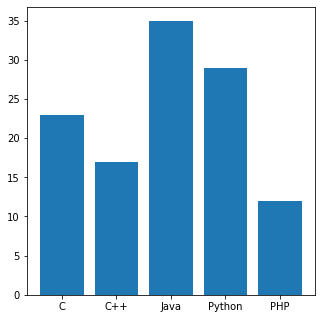

In [7]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4,4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['C', 'C++', 'Java', 'Python', 'PHP']
students = [23,17,35,29,12]
ax.bar(langs,students)
plt.show()